In [12]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import shutil
import random
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms as transform
from torch.utils.data import DataLoader
from ultralytics import YOLO
import yaml


## Data preprocessing


In [3]:
data_dir = 'data/mri_brain_multi'
print(os.listdir(data_dir))


['Testing', 'Training']


In [16]:
source_root = 'data/mri_brain_detection'  
target_root = 'data/mri_brain_detection_reduced' 
subsets = ['train', 'valid', 'test'] 
n_samples = {
    'train': 100,  # Number of images for training
    'valid': 20,   # Number of images for validation
    'test': 20     # Number of images for test
}

random.seed(42)

for subset in subsets:
    
    src_img_path = os.path.join(source_root, subset, 'images')
    src_lab_path = os.path.join(source_root, subset, 'labels')
    
    dst_img_path = os.path.join(target_root, subset, 'images')
    dst_lab_path = os.path.join(target_root, subset, 'labels')
    
    os.makedirs(dst_img_path, exist_ok=True)
    os.makedirs(dst_lab_path, exist_ok=True)
    
    if os.path.exists(src_img_path):
        # List the images
        all_images = [f for f in os.listdir(src_img_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Random selection
        n_to_sample = min(len(all_images), n_samples[subset])
        selected_images = random.sample(all_images, n_to_sample)
        
        for img_name in selected_images:
            # Copy the image
            shutil.copy(os.path.join(src_img_path, img_name), 
                        os.path.join(dst_img_path, img_name))
            
            # Copy the matching label (.txt)
            label_name = os.path.splitext(img_name)[0] + '.txt'
            src_label = os.path.join(src_lab_path, label_name)
            
            if os.path.exists(src_label):
                shutil.copy(src_label, os.path.join(dst_lab_path, label_name))
            else:
                print(f"Warning : Missing label for {img_name}")

# Copy the data.yaml file (useful for YOLO)
src_yaml = os.path.join(source_root, 'data.yaml')
if os.path.exists(src_yaml):
    shutil.copy(src_yaml, os.path.join(target_root, 'data.yaml'))
    print("File data.yaml copied.")

print(f"Detection dataset reduced created in '{target_root}'.")

File data.yaml copied.
Detection dataset reduced created in 'data/mri_brain_detection_reduced'.


In [5]:
class AddGaussianNoise(object):
    """
    Add a standard Gaussian noise."""
    def __init__(self, mean=0., std=0.05):
        self.std = std
        self.mean = mean
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

class AddRicianNoise(object):
    """
    Add a standard Rician noise.
    Formula : sqrt((I + n_re)^2 + n_im^2)
    """
    def __init__(self, sigma=0.01):
        self.sigma = sigma

    def __call__(self, tensor):
        noise_shape = [1, tensor.size(1), tensor.size(2)]
        
        n_re = torch.randn(noise_shape) * self.sigma
        n_im = torch.randn(noise_shape) * self.sigma
        
        noisy = torch.sqrt((tensor + n_re)**2 + n_im**2)
        
        return noisy

In [6]:
def generate_noisy_yolo_dataset(source_dir, target_dir, noise_type=None, sigma=0.05):
    """
    Generate a YOLO dataset with added noise (Gaussian or Rician) for the images.
    """
    # Transformations: Grayscale + ToTensor + Noise
    trans_list = [transform.Grayscale(1), transform.ToTensor()]
    if noise_type == 'gaussian':
        trans_list.append(AddGaussianNoise(std=sigma))
    elif noise_type == 'rician':
        trans_list.append(AddRicianNoise(sigma=sigma))
    
    # No need to normalize since we will save the noisy images directly as uint8 after processing
    pipeline = transform.Compose(trans_list)

    for subset in ['train', 'valid', 'test']:
        img_src = os.path.join(source_dir, subset, 'images')
        img_dst = os.path.join(target_dir, subset, 'images')
        lab_src = os.path.join(source_dir, subset, 'labels')
        lab_dst = os.path.join(target_dir, subset, 'labels')
        
        os.makedirs(img_dst, exist_ok=True)
        os.makedirs(lab_dst, exist_ok=True)

        if not os.path.exists(img_src): continue

        for img_name in os.listdir(img_src):
            # Image loading and conversion to grayscale
            path = os.path.join(img_src, img_name)
            img = Image.open(path).convert('L')
            
            # Pipeline application
            img_tensor = pipeline(img)
            
            # Save to numpy
            img_noisy = img_tensor.squeeze().numpy()
            img_noisy = (np.clip(img_noisy, 0, 1) * 255).astype(np.uint8)
            
            cv2.imwrite(os.path.join(img_dst, img_name), img_noisy)

            # No label change
            label_name = os.path.splitext(img_name)[0] + '.txt'
            if os.path.exists(os.path.join(lab_src, label_name)):
                shutil.copy(os.path.join(lab_src, label_name), os.path.join(lab_dst, label_name))



In [7]:
sigma_val = 0.05
source = 'data/mri_brain_detection_reduced'

# Scenario 1: Baseline 
generate_noisy_yolo_dataset(source, 'yolo/yolo_base', noise_type=None)

# Scenario 2: Gaussian
generate_noisy_yolo_dataset(source, 'yolo/yolo_gauss', noise_type='gaussian', sigma=sigma_val)

# Scenario 3: Rician 
generate_noisy_yolo_dataset(source, 'yolo/yolo_rice', noise_type='rician', sigma=sigma_val)

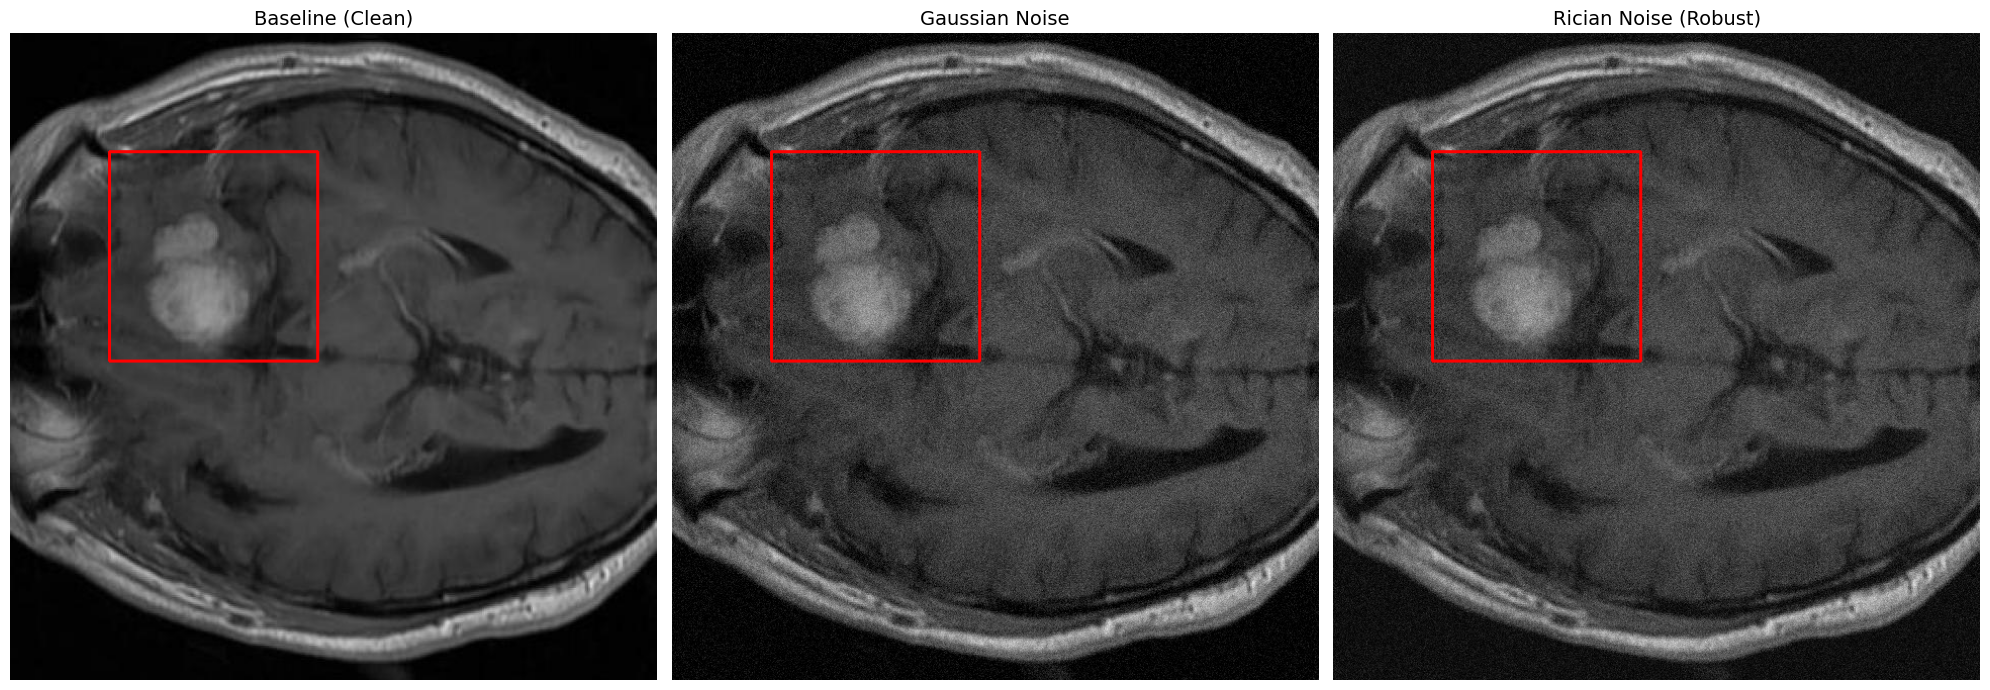

In [ ]:
def visualize_yolo_scenarios(image_name, base_folder, gauss_folder, rice_folder, subset='train'):
    """
    Plot the same image with its labels for the 3 noise scenarios (Baseline, Gaussian, Rician).
    """
    folders = [base_folder, gauss_folder, rice_folder]
    titles = ["Baseline (Clean)", "Gaussian Noise", "Rician Noise (Robust)"]
    
    plt.figure(figsize=(20, 8))
    
    for i, folder in enumerate(folders):
        img_path = os.path.join(folder, subset, 'images', image_name)
        label_path = os.path.join(folder, subset, 'labels', os.path.splitext(image_name)[0] + '.txt')
        
        # Load the image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape
        
        # Draw bounding boxes if label exists
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.split()
                    # YOLO format : class x_center y_center width height 
                    cls, x, y, nw, nh = map(float, parts[:5])
                    
                    # Conversion in pixel coordinates
                    x1 = int((x - nw/2) * w)
                    y1 = int((y - nh/2) * h)
                    x2 = int((x + nw/2) * w)
                    y2 = int((y + nh/2) * h)
                    
                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        
        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.title(titles[i], fontsize=14)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


base_folder_reduced = 'yolo_reduced/yolo_base'
gauss_folder_reduced = 'yolo_reduced/yolo_gauss'
rice_folder_reduced = 'yolo_reduced/yolo_rice'

# Remplacez par le nom d'une image présente dans vos dossiers
example_img = os.listdir('yolo_reduced/yolo_base/train/images')[0] 
visualize_yolo_scenarios(example_img, base_folder_reduced, gauss_folder_reduced, rice_folder_reduced)

## Training the YOLO model on the reduced dataset

In [ ]:
def prepare_and_train_yolo(scenario_name, data_dir, project_folder, epochs=4):
    """
    Update the YAML to point to the correct noise folder and launch training.
    """
    source_yaml = 'yolo_reduced/data.yaml'  
    target_yaml = os.path.join(data_dir, 'data_temp.yaml') # YAML for the scenario
    
    # Laod and modify the YAML path
    with open(source_yaml, 'r') as f:
        data_config = yaml.safe_load(f)
    
    # We enforce the path to the specific folder (yolo_base, yolo_rice, yolo_gauss)
    data_config['path'] = os.path.abspath(data_dir)
    
    with open(target_yaml, 'w') as f:
        yaml.dump(data_config, f)
        
    # Training the YOLOv11 model (using a small pre-trained model for speed, adjust as needed)
    model = YOLO('yolo11n.pt')
    results = model.train(
        data=target_yaml,
        epochs=epochs,
        imgsz=224,
        project=project_folder,
        name=scenario_name,
        device='cpu'  # Assurez-vous d'avoir un GPU, sinon mettez 'cpu'
    )
    return model, results



In [ ]:
n_epochs_yolo = 4
project_folder = "MRI_Brain_Detection"

# BASELINE
model_yolo_base, results_base = prepare_and_train_yolo(
    "Baseline", 'yolo_reduced/yolo_base', project_folder, epochs=n_epochs_yolo
)

# GAUSSIAN
model_yolo_gauss, results_gauss = prepare_and_train_yolo(
    "Gaussian", 'yolo_reduced/yolo_gauss', project_folder, epochs=n_epochs_yolo
)

# RICIAN
model_yolo_rice, results_rice = prepare_and_train_yolo(
    "Rician", 'yolo_reduced/yolo_rice', project_folder, epochs=n_epochs_yolo
)

New https://pypi.org/project/ultralytics/8.4.13 available  Update with 'pip install -U ultralytics'
Ultralytics 8.4.9  Python-3.13.12 torch-2.9.1+cpu CPU (11th Gen Intel Core i5-1135G7 @ 2.40GHz)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo/yolo_base\data_temp.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=4, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=Bas

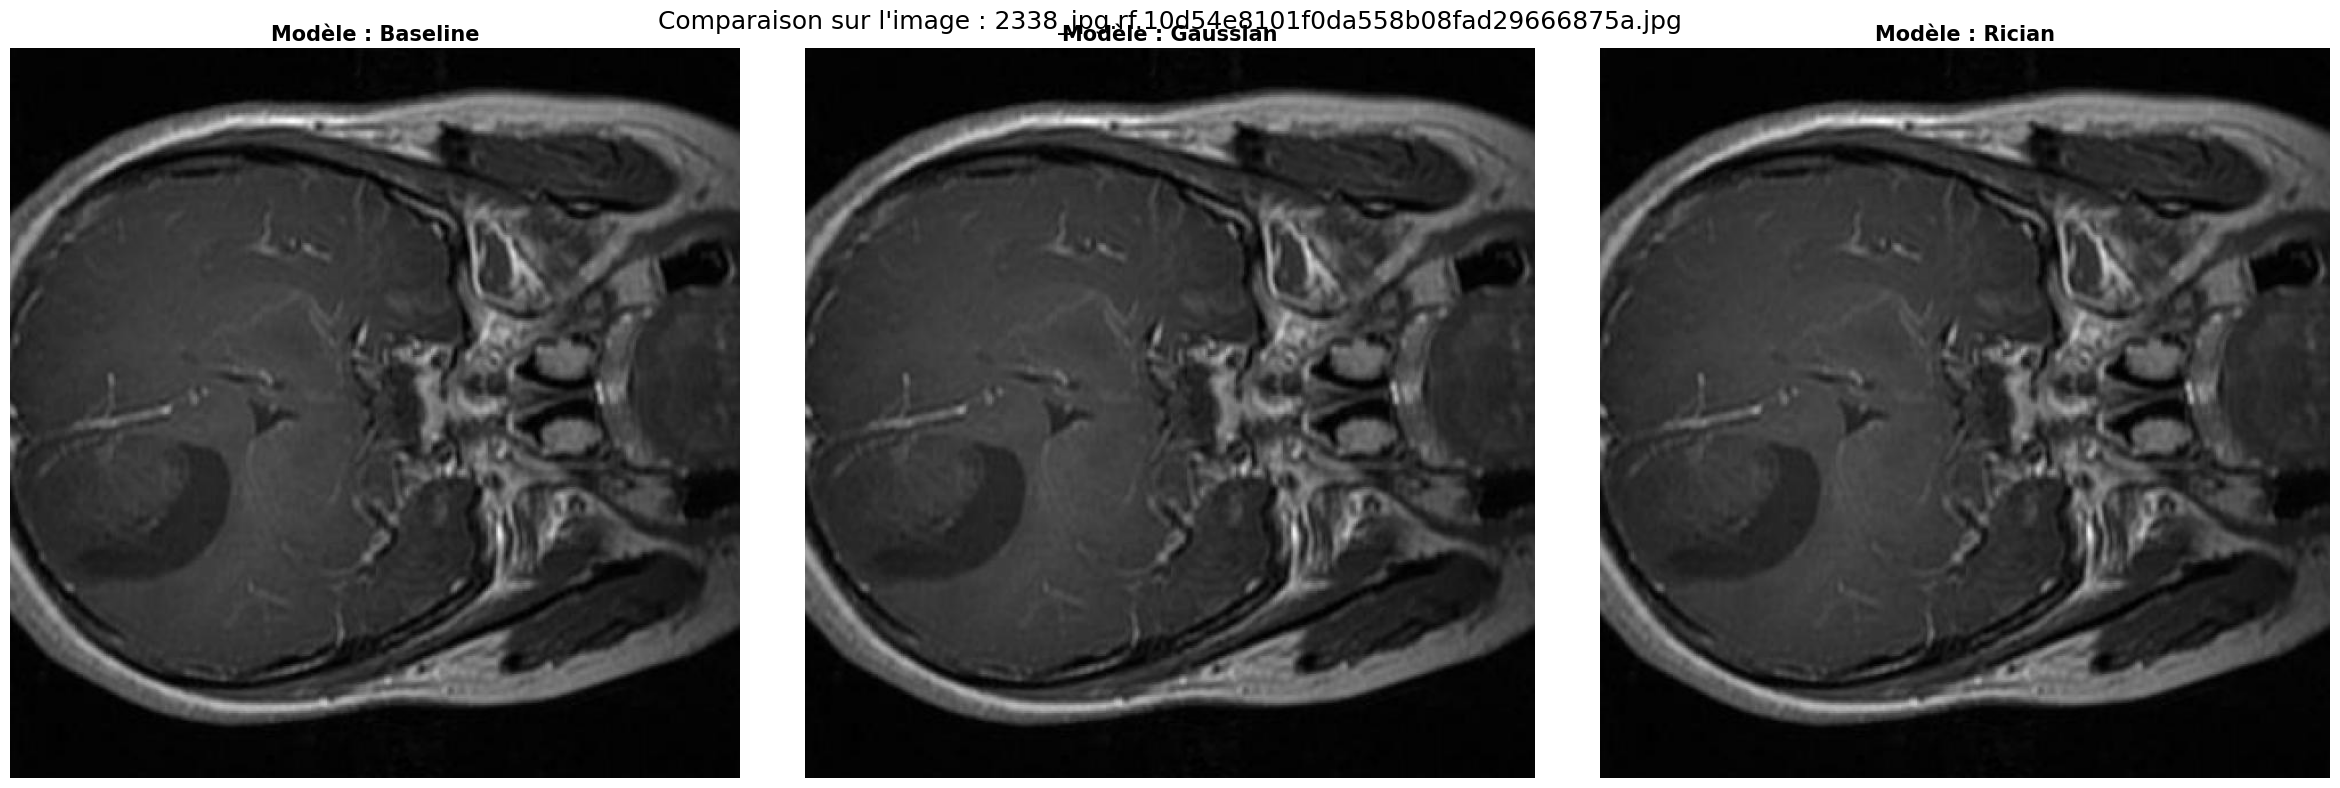

In [11]:
def compare_all_yolo_scenarios(test_dir, model_paths):
    """
    Select a random test image and compare the predictions of the 3 YOLO models.
    model_paths: dict {'Baseline': path, 'Gaussian': path, 'Rician': path}
    """
    # Randomly select a test image
    test_images_path = os.path.join(test_dir, 'images')
    available_images = [f for f in os.listdir(test_images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not available_images:
        print("Error : No images found in the test folder.")
        return

    random_image = random.choice(available_images)
    image_path = os.path.join(test_images_path, random_image)
    
    # Plotting setup
    plt.figure(figsize=(24, 8))
    
    for i, (name, path) in enumerate(model_paths.items()):
        if not os.path.exists(path):
            print(f"Warning : the model {name} is not found at path {path}")
            continue
            
        # Loading and prediction
        model = YOLO(path)
        results = model.predict(image_path, imgsz=224, conf=0.25, verbose=False)
        
        # Generate annotated image with predictions
        annotated_img = results[0].plot()
        # Conversion for matplotlib
        annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(1, 3, i + 1)
        plt.imshow(annotated_img)
        plt.title(f"Modèle : {name}", fontsize=15, fontweight='bold')
        plt.axis('off')

    plt.suptitle(f"Comparaison sur l'image : {random_image}", fontsize=18)
    plt.tight_layout()
    plt.show()


paths = {
    'Baseline': 'runs/detect/MRI_Brain_Detection/Baseline/weights/best.pt',
    'Gaussian': 'runs/detect/MRI_Brain_Detection/Gaussian/weights/best.pt',
    'Rician':   'runs/detect/MRI_Brain_Detection/Rician/weights/best.pt'
}

test_folder = 'yolo/yolo_base/test' 

compare_all_yolo_scenarios(test_folder, paths)

In [14]:
def evaluate_yolo_models(model_paths, test_yaml_path):
    """
    Compares models on the same test set and returns a DataFrame with their metrics.
    model_paths: dict {'Clean': 'path/to/best.pt', 'Rice': ...}
    """
    results_list = []

    for scenario, path in model_paths.items():
        print(f"Evaluating the scenario : {scenario}")
        model = YOLO(path)
        metrics = model.val(data=test_yaml_path, split='test')

        # Extract the main metrics
        results_list.append({
            'Scenario': scenario,
            'mAP50': metrics.box.map50,
            'mAP50-95': metrics.box.map,
            'Precision': metrics.box.mp,
            'Recall': metrics.box.mr,
            'Fitness': metrics.fitness
        })
        
    return pd.DataFrame(results_list)

def plot_comparison(df):
    df.set_index('Scenario')[['mAP50', 'mAP50-95']].plot(kind='bar', figsize=(10, 6))
    plt.title('Impact of noise augmentation on object detection (YOLOv11)')
    plt.ylabel('Score')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='lower right')
    plt.show()

Evaluating the models on the same test set...
Evaluating the scenario : Baseline
Ultralytics 8.4.9  Python-3.13.12 torch-2.9.1+cpu CPU (11th Gen Intel Core i5-1135G7 @ 2.40GHz)
YOLO11n summary (fused): 101 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 2.00.5 MB/s, size: 32.7 KB)
val: Scanning C:\Users\DELL\Desktop\Cours 3A\SM10\Deep Learning\Projet\Pneumonia-Detection\data\mri_brain_detection_reduced\test\labels... 20 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 20/20 290.8it/s 0.1s
val: New cache created: C:\Users\DELL\Desktop\Cours 3A\SM10\Deep Learning\Projet\Pneumonia-Detection\data\mri_brain_detection_reduced\test\labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 3.0it/s 0.7s1.5s
                   all         20         20    0.00256       0.75    0.00657     0.0036
                glioma          8          8    0.00207      0.625    0.00448  

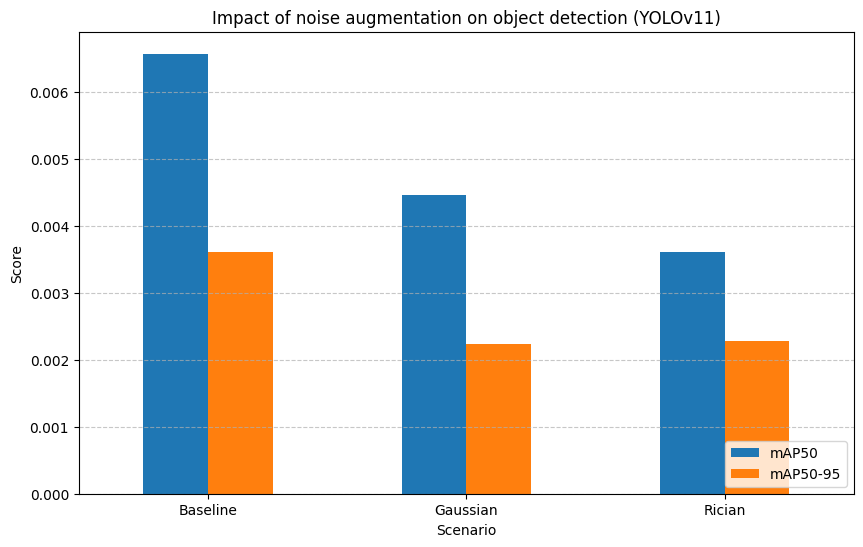

,Scenario,mAP50,mAP50-95,Precision,Recall,Fitness
0,Baseline,0.006571,0.003602,0.002560,0.750000,0.003602
1,Gaussian,0.004455,0.002238,0.001811,0.583333,0.002238
2,Rician,0.003605,0.002280,0.001916,0.583333,0.002280


In [17]:
project_folder = 'Brain_Tumor_Study'

paths = {
    'Baseline': 'runs/detect/MRI_Brain_Detection/Baseline/weights/best.pt',
    'Gaussian': 'runs/detect/MRI_Brain_Detection/Gaussian/weights/best.pt',
    'Rician':   'runs/detect/MRI_Brain_Detection/Rician/weights/best.pt'
}

reduced_dir = 'data/mri_brain_detection_reduced'
test_yaml = os.path.join(reduced_dir, 'data.yaml')

print("Evaluating the models on the same test set...")


df_comparatif = evaluate_yolo_models(paths, test_yaml)

print("\n Plotting the metrics")
plot_comparison(df_comparatif)

display(df_comparatif)

## Training the YOLO model on the whole dataset

In [ ]:
sigma_val = 0.05
source = 'data/mri_brain_detection'

# Scenario 1: Baseline 
generate_noisy_yolo_dataset(source, 'yolo/yolo_base', noise_type=None)

# Scenario 2: Gaussian
generate_noisy_yolo_dataset(source, 'yolo/yolo_gauss', noise_type='gaussian', sigma=sigma_val)

# Scenario 3: Rician 
generate_noisy_yolo_dataset(source, 'yolo/yolo_rice', noise_type='rician', sigma=sigma_val)

In [ ]:
n_epochs_yolo = 10
project_folder = "MRI_Brain_Detection"

# BASELINE
model_yolo_base, results_base = prepare_and_train_yolo(
    "Baseline", 'yolo/yolo_base', project_folder, epochs=n_epochs_yolo
)

# GAUSSIAN
model_yolo_gauss, results_gauss = prepare_and_train_yolo(
    "Gaussian", 'yolo/yolo_gauss', project_folder, epochs=n_epochs_yolo
)

# RICIAN
model_yolo_rice, results_rice = prepare_and_train_yolo(
    "Rician", 'yolo/yolo_rice', project_folder, epochs=n_epochs_yolo
)